In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
#env_path = os.environ.get('CONDA_PREFIX')
#os.environ["HADOOP_HOME"] = os.path.join(env_path, "Library")
#os.environ["PATH"] = os.environ["PATH"] + os.pathsep + os.path.join(env_path, "Library", "bin")
#os.environ["JAVA_HOME"] = os.path.join(env_path, "Library")


spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Python Spark SQL basic example")\
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/29 15:03:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/29 15:03:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
schema = StructType([
    StructField('hour_of_day', IntegerType(), nullable = False),
    StructField('day_of_week', IntegerType(), nullable = False),
    StructField('month', IntegerType(), nullable = False),
    StructField('holiday', IntegerType(), nullable = False),
    StructField('weekday', IntegerType(), nullable = False),
    StructField('summertime', IntegerType(), nullable = False),
    StructField('temp', DoubleType(), nullable = False),
    StructField('dew', DoubleType(), nullable = False),
    StructField('humidity', DoubleType(), nullable = False),
    StructField('precip', DoubleType(), nullable = False),
    StructField('snow', DoubleType(), nullable = False),
    StructField('snowdepth', DoubleType(), nullable = False),
    StructField('windspeed', DoubleType(), nullable = False),
    StructField('cloudcover', DoubleType(), nullable = False),
    StructField('visibility', DoubleType(), nullable = False),
    StructField('increase_stock', StringType(), nullable = False)
])

data = spark.read.csv('training_data_ht2025.csv', header = True, schema = schema).persist()

In [4]:
data.show()

+-----------+-----------+-----+-------+-------+----------+----+-----+--------+------+----+---------+---------+----------+----------+----------------+
|hour_of_day|day_of_week|month|holiday|weekday|summertime|temp|  dew|humidity|precip|snow|snowdepth|windspeed|cloudcover|visibility|  increase_stock|
+-----------+-----------+-----+-------+-------+----------+----+-----+--------+------+----+---------+---------+----------+----------+----------------+
|          5|          5|    1|      0|      0|         0|-7.2|-15.0|   53.68|   0.0| 0.0|      0.0|     16.3|      31.6|      16.0| low_bike_demand|
|         21|          4|    1|      0|      1|         0|-1.3|-12.8|   40.97|   0.0| 0.0|      0.0|     23.9|      85.7|      16.0| low_bike_demand|
|         21|          3|    8|      0|      1|         1|26.9| 21.8|   73.39|   0.0| 0.0|      0.0|      0.0|      81.1|      16.0| low_bike_demand|
|          1|          6|    1|      0|      0|         0| 3.1| -4.0|   59.74|   0.0| 0.0|      0.0|

In [5]:
data.printSchema()

root
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- summertime: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- increase_stock: string (nullable = true)



# data analysis task

### Q1: hich are the numerical features and which are the categorical features?

categorical: 
- hour_of_day (number, 0 - 23)
- day_of_week (number, 0 - 6)
- month (number, 1 - 12)
- holiday (boolean, 0 - 1)
- weekday (boolean, 0 - 1)
- summertime (boolean, 0 - 1)
- increase_stock (string)

numerical: 
- temp (double)
- dew (double)
- precip (double)
- snow (double)
- snowdepth (double)
- windspeed (double)
- cloudcover (double)
- visibility (double)

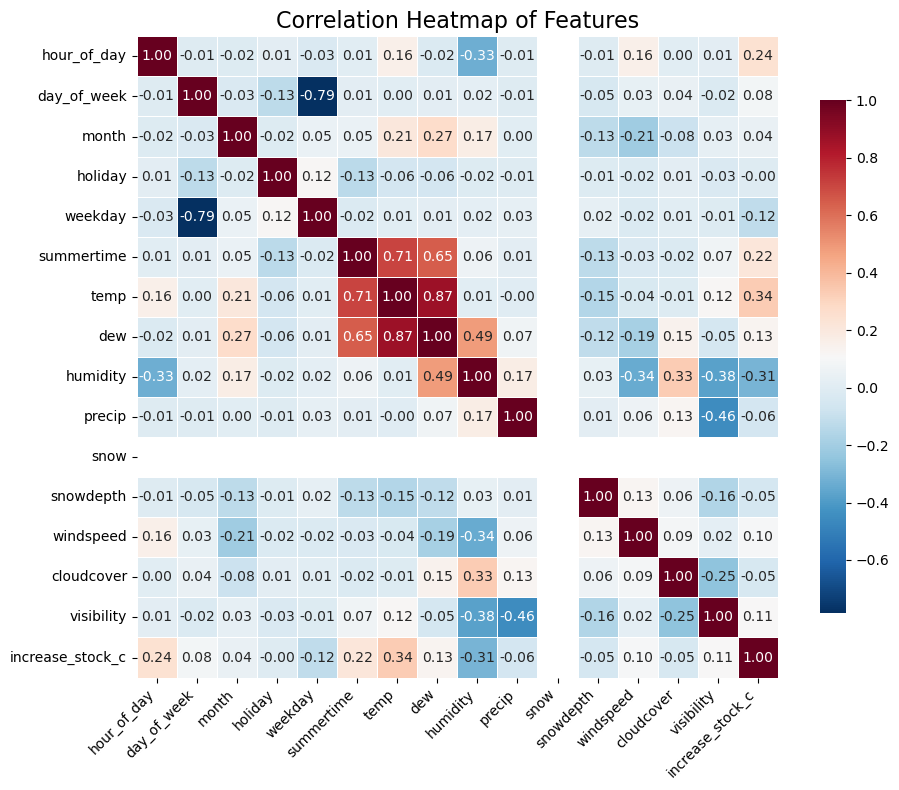

In [6]:
datapd = data\
    .withColumn('increase_stock_c', F.when(F.col('increase_stock') == 'high_bike_demand', F.lit(1)).otherwise(F.lit(0)))\
    .drop(F.col('increase_stock'))\
    .toPandas()

correlation_matrix = datapd.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,      
    fmt=".2f",
    cmap='RdBu_r',
    cbar=True,
    square=True,
    linewidths=.5,
    cbar_kws={'shrink': 0.8}
)

# Customize the plot
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

In [7]:
data.groupBy(F.col('hour_of_day')).agg(F.count('*')).sort(F.asc('hour_of_day')).show(n=24)

+-----------+--------+
|hour_of_day|count(1)|
+-----------+--------+
|          0|      84|
|          1|      67|
|          2|      53|
|          3|      69|
|          4|      69|
|          5|      67|
|          6|      62|
|          7|      77|
|          8|      66|
|          9|      63|
|         10|      63|
|         11|      58|
|         12|      66|
|         13|      78|
|         14|      70|
|         15|      64|
|         16|      83|
|         17|      72|
|         18|      53|
|         19|      57|
|         20|      55|
|         21|      71|
|         22|      56|
|         23|      77|
+-----------+--------+



In [9]:
data.groupBy(F.col('day_of_week')).agg(F.count('*')).sort(F.asc('day_of_week')).show(n=24)

+-----------+--------+
|day_of_week|count(1)|
+-----------+--------+
|          0|     240|
|          1|     211|
|          2|     223|
|          3|     220|
|          4|     242|
|          5|     233|
|          6|     231|
+-----------+--------+



In [10]:
data.groupBy(F.col('month')).agg(F.count('*')).sort(F.asc('month')).show(n=24)

+-----+--------+
|month|count(1)|
+-----+--------+
|    1|     128|
|    2|     131|
|    3|     147|
|    4|     140|
|    5|     133|
|    6|     137|
|    7|     136|
|    8|     121|
|    9|     131|
|   10|     119|
|   11|     141|
|   12|     136|
+-----+--------+



In [68]:
data.show(n=2)

+-----------+-----------+-----+-------+-------+----------+----+-----+--------+------+----+---------+---------+----------+----------+---------------+
|hour_of_day|day_of_week|month|holiday|weekday|summertime|temp|  dew|humidity|precip|snow|snowdepth|windspeed|cloudcover|visibility| increase_stock|
+-----------+-----------+-----+-------+-------+----------+----+-----+--------+------+----+---------+---------+----------+----------+---------------+
|          5|          5|    1|      0|      0|         0|-7.2|-15.0|   53.68|   0.0| 0.0|      0.0|     16.3|      31.6|      16.0|low_bike_demand|
|         21|          4|    1|      0|      1|         0|-1.3|-12.8|   40.97|   0.0| 0.0|      0.0|     23.9|      85.7|      16.0|low_bike_demand|
+-----------+-----------+-----+-------+-------+----------+----+-----+--------+------+----+---------+---------+----------+----------+---------------+
only showing top 2 rows



In [74]:
ohe_cols = ['hour_of_day', 'day_of_week', 'month'] 
ohe_expressions = []

for col_name in ohe_cols:
    distinct_df = data.select(F.col(col_name).cast(IntegerType()).alias('value')).distinct().orderBy('value')
    distinct_values = [row['value'] for row in distinct_df.collect()]
    
    for value in distinct_values:
        new_col_name = f"{col_name}_{value}"

        expr = (
            F.when(F.col(col_name) == value, F.lit(1))
             .otherwise(F.lit(0))
             .alias(new_col_name)
        )
        ohe_expressions.append(expr)

cleandata = data.select(
    *ohe_expressions,
    F.col('holiday'),
    F.col('weekday'),
    F.col('summertime'),
    F.col('dew'),
    F.col('humidity'),
    F.col('precip'),
    F.col('snow'),
    F.col('snowdepth'),
    F.col('windspeed'),
    F.col('cloudcover'),
    F.col('visibility'),
    F.when(F.col('increase_stock') == 'high_bike_demand', F.lit(1)).otherwise(F.lit(0)).alias('increase_stock')
)


In [75]:
cleandata.limit(10).toPandas()

,hour_of_day_0,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,...,summertime,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,0,0,0,0,0,1,0,0,0,0,...,0,-15.0,53.68,0.0,0.0,0.0,16.3,31.6,16.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,-12.8,40.97,0.0,0.0,0.0,23.9,85.7,16.0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,21.8,73.39,0.0,0.0,0.0,0.0,81.1,16.0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,-4.0,59.74,0.0,0.0,0.0,19.2,0.0,16.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,-11.4,18.71,0.0,0.0,0.0,10.5,44.6,16.0,0
5,0,0,0,0,0,0,0,0,0,0,...,1,12.8,40.98,0.0,0.0,0.0,13.6,81.3,16.0,1
6,0,0,0,0,0,0,0,0,0,0,...,1,24.3,67.71,0.0,0.0,0.0,20.3,50.3,16.0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,-1.7,62.46,0.0,0.0,0.0,21.5,100.0,16.0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,13.8,83.56,0.0,0.0,0.0,18.1,88.9,16.0,0
9,0,0,0,0,0,0,0,1,0,0,...,0,-12.2,55.14,0.0,0.0,0.0,12.4,24.4,16.0,0


In [80]:
cleandata.toPandas().to_csv('training_data.csv')